In [ ]:
"""
This example demonstrates the impact of the C band hail reflectivity 
(Brook et al. 2023 https://arxiv.org/abs/2306.12016) using overlapping C and S band radars
for the Sydney 20-12-2018 hailstorm
"""

In [1]:
import os
from urllib import request

from matplotlib import pyplot as plt
import numpy as np
import cartopy.crs as ccrs 

import pyart
from pyhail import mesh_ppi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#config
cband_radar_url  = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/54_20181220_052503.pvol.h5'
sband_radar_url  = 'https://pyhail-public.s3.ap-southeast-2.amazonaws.com/71_20181220_052428.pvol.h5'
cband_refl_offset = -5.08 #dBZ
sband_refl_offset = 1.51 #dBZ
freezing_level = 3000 #m
minus20_level = 5000 #m
max_lat = -33.5
min_lat = -34.2
max_lon = 150.8
min_lon = 151.5
n_grid_lines = 5
lat_lines = np.linspace(min_lat, max_lat, n_grid_lines)
lon_lines = np.linspace(min_lon, max_lon, n_grid_lines)

In [3]:
def _create_ppi_plot(pyart_disp, subplot_idx, fieldname, tilt, vmin, vmax, cmap=None, title=None, subplot_ncols=2, subplot_nrows=2):
    """
    subplot creation function
    """
    #create subplot axis
    ax=plt.subplot(subplot_ncols, subplot_nrows, subplot_idx, projection=ccrs.PlateCarree())
    if cmap is None:
        pyart_disp.plot_ppi_map(fieldname,tilt, vmin=vmin, vmax=vmax, resolution = '10m', ax=ax,
                                max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                                lat_lines = lat_lines, lon_lines = lon_lines, title=title)
    else:
        pyart_disp.plot_ppi_map(fieldname,tilt, vmin=vmin, vmax=vmax, resolution = '10m', ax=ax,
                                max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                                lat_lines = lat_lines, lon_lines = lon_lines,
                                cmap=cmap, title=title)

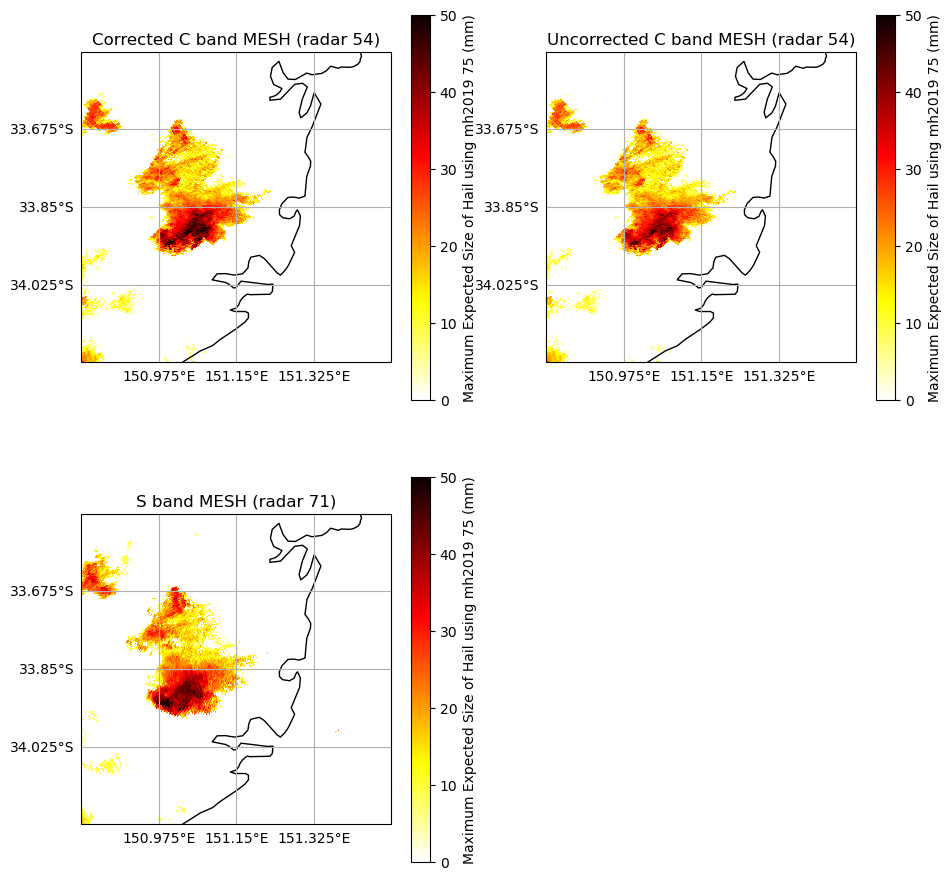

In [5]:
#download example data
tmp_path    = '/tmp/pyhail_example_data'
if not os.path.exists(tmp_path):
    os.makedirs(tmp_path)
cband_radar_ffn    = f'{tmp_path}/54_20181220_052503.pvol.h5'
sband_radar_ffn    = f'{tmp_path}/71_20181220_052428.pvol.h5'
request.urlretrieve(cband_radar_url, cband_radar_ffn)
request.urlretrieve(sband_radar_url, sband_radar_ffn)

#read example data
cband_radar = pyart.aux_io.read_odim_h5(cband_radar_ffn)
cband_radar_c_correct = pyart.aux_io.read_odim_h5(cband_radar_ffn)
sband_radar = pyart.aux_io.read_odim_h5(sband_radar_ffn)

#calibrate reflectivity
cband_cal_refl = cband_radar.fields['reflectivity_horizontal']['data'] - cband_refl_offset
cband_radar.add_field_like('reflectivity_horizontal', 'corrected_reflectivity', cband_cal_refl)
cband_cal_refl = cband_radar_c_correct.fields['reflectivity_horizontal']['data'] - cband_refl_offset
cband_radar_c_correct.add_field_like('reflectivity_horizontal', 'corrected_reflectivity', cband_cal_refl)
sband_cal_refl = sband_radar.fields['reflectivity_horizontal']['data'] - sband_refl_offset
sband_radar.add_field_like('reflectivity_horizontal', 'corrected_reflectivity', sband_cal_refl)

#run mesh retrievals
cband_radar = mesh_ppi.pyart(cband_radar, 'corrected_reflectivity', temp_levels=[freezing_level, minus20_level], min_range=10, max_range=150,
                 mesh_method='mh2019_75', radar_band='C', correct_cband_refl=False)
cband_radar_c_correct = mesh_ppi.pyart(cband_radar_c_correct, 'corrected_reflectivity', temp_levels=[freezing_level, minus20_level], min_range=10, max_range=150,
                 mesh_method='mh2019_75', radar_band='C', correct_cband_refl=True)
sband_radar = mesh_ppi.pyart(sband_radar, 'corrected_reflectivity', temp_levels=[freezing_level, minus20_level], min_range=10, max_range=150,
                 mesh_method='mh2019_75', radar_band='S', correct_cband_refl=True)

#plot
fig = plt.figure(figsize=[11,11])
cband_c_correct_display = pyart.graph.RadarMapDisplay(cband_radar_c_correct)
_create_ppi_plot(cband_c_correct_display, 1, 'mesh', 0, 0, 50, cmap='hot_r', title='Corrected C band MESH (radar 54)')
cband_c_display = pyart.graph.RadarMapDisplay(cband_radar)
_create_ppi_plot(cband_c_display, 2, 'mesh', 0, 0, 50, cmap='hot_r', title='Uncorrected C band MESH (radar 54)')
sband_display = pyart.graph.RadarMapDisplay(sband_radar)
_create_ppi_plot(sband_display, 3, 'mesh', 0, 0, 50, cmap='hot_r', title='S band MESH (radar 71)')